# Waterwell Project

Purpose: The purpose of this project is to create a model that can accurately predict whether a waterwell is functional or not. The two metrics that will be considered is the overall accuracy of the model and also the recall score for non-functional wells.

# Packages and Functions

In [3]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel



## Fix to six error
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE, ADASYN

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

In [4]:
def eval_model(model, X_train, y_train, X_test, y_test):
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    print('Training Precision: ', precision_score(y_train, y_hat_train, average='macro'))
    print('Testing Precision: ', precision_score(y_test, y_hat_test, average='macro'))
    print('\n\n')

    print('Training Recall: ', recall_score(y_train, y_hat_train, average='macro'))
    print('Testing Recall: ', recall_score(y_test, y_hat_test, average='macro'))
    print('\n\n')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('\n\n')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train, average='macro'))
    print('Testing F1-Score: ', f1_score(y_test, y_hat_test, average='macro'))
    print('\n\n')
    
    print(classification_report(y_test,y_hat_test))
    
    plot_confusion_matrix(model, X_test, y_test)
    
    return

# EDA

## Initial look at data and upload

In [5]:
# Import "Training Data" Which is going to be are actual data set
X_data = pd.read_csv('TrainingSet.csv')
y_data = pd.read_csv('TrainingSetLabels.csv')

In [6]:
# Merge just to check it out
Full_data = pd.merge(X_data, y_data, left_on='id', right_on='id')

In [7]:
Full_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [8]:
Full_data.shape

(59400, 41)

In [9]:
#Checking for class inbalance
Full_data['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [10]:
Full_data_1 = pd.merge(X_data, y_data, left_on='id', right_on='id')

Text(0.5, 1.0, 'Number of wells in each Status')

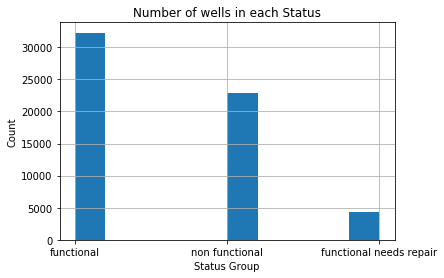

In [11]:
Full_data_1.status_group.hist()
plt.xlabel('Status Group')
plt.ylabel('Count')
plt.title('Number of wells in each Status')

Don't really see much of class inbalance besides funcitonal/needs repair class

In [12]:
Full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Checking the Nan entries

In [13]:
print('These are the columns with nan values in the dataframe.')
Full_data.columns[Full_data.isna().any()].tolist()

These are the columns with nan values in the dataframe.


['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

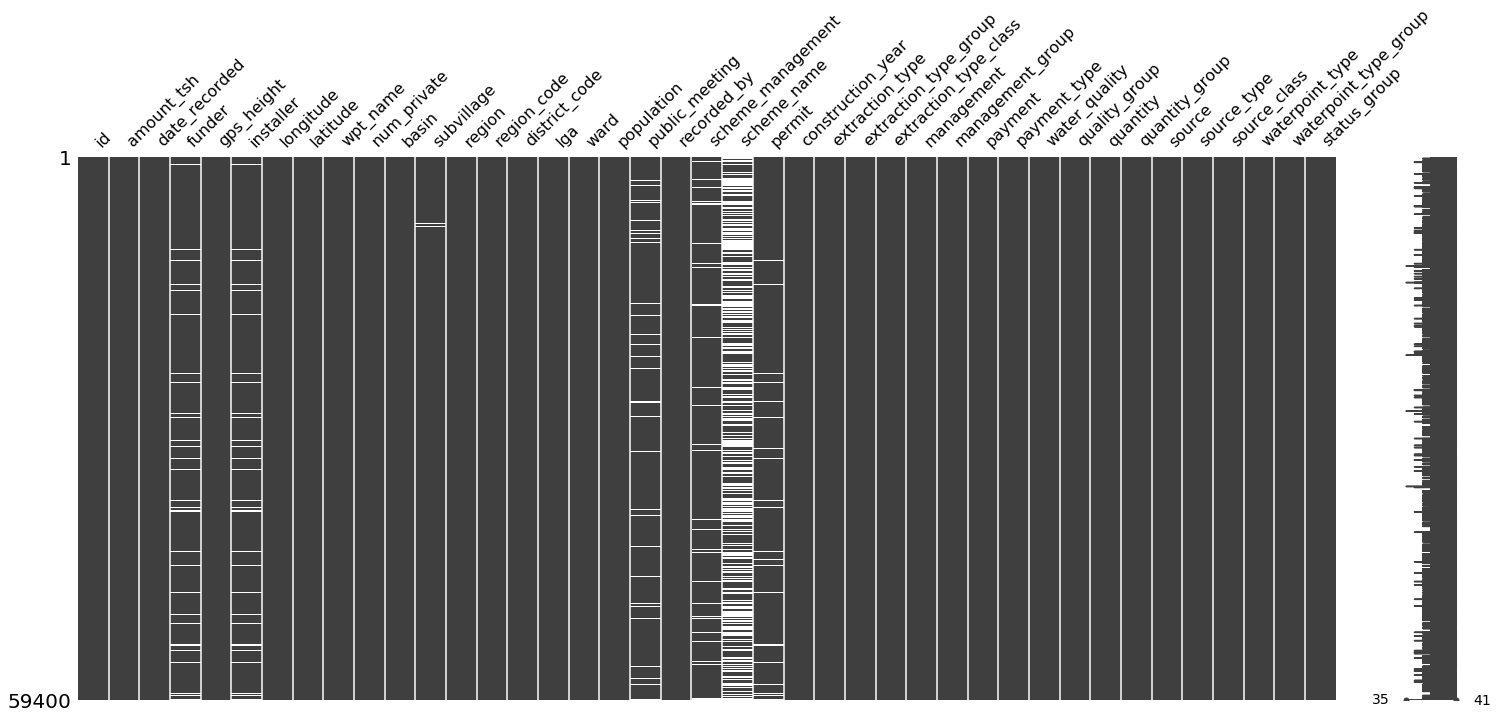

In [14]:
msno.matrix(Full_data)

In [15]:
# The missing data might be important so lets fill funder na using KNN imputation
Full_data.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Legeza Legeza                1
Namungo Miners               1
Noshadi                      1
Daida                        1
Sumriy                       1
Name: funder, Length: 1897, dtype: int64

In [16]:
# This missing data might be important too so lets fill installer na using KNN imputation
Full_data.installer.value_counts()

DWE                 17402
Government           1825
RWE                  1206
Commu                1060
DANIDA               1050
                    ...  
Christina Magoge        1
ACTION AID              1
Al Ha                   1
Mwamama                 1
Mwita Mahiti            1
Name: installer, Length: 2145, dtype: int64

In [17]:
# This missing data might be important too so lets fill subvillage na using KNN imputation
Full_data.subvillage.value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
             ... 
Ahakabare       1
Miranda         1
Wilungwa A      1
Mwamili         1
Nyamajiwa       1
Name: subvillage, Length: 19287, dtype: int64

In [18]:
# This missing data might be important too so lets fill public_meeting na as Unknown (done in preprocessing section)
Full_data.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [19]:
# there is too much missing data on scheme_name and i believe scheme_management is giving same info
# Lets drop scheme_name
print(Full_data.scheme_name.isna().sum())
Full_data.scheme_name.value_counts()

28166


K                              682
None                           644
Borehole                       546
Chalinze wate                  405
M                              400
                              ... 
lgongolo gravity water sche      1
Tove - Mtwango                   1
Rundugu                          1
Mchangani                        1
Mkoy                             1
Name: scheme_name, Length: 2696, dtype: int64

In [20]:
# This missing data might be important too so lets fill scheme_management na using KNN imputation
Full_data.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [21]:
# Probably safe to say that if you don't know you have a permit, its a no
Full_data.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [22]:
# Filling nan values just to look through data easier

Full_data[['funder', 'installer', 'public_meeting']] = Full_data[['funder', 'installer',
                                                                               'public_meeting']].fillna(value='Unknown')

Full_data[['subvillage', 'scheme_management']] = Full_data[['subvillage',
                                                                         'scheme_management']].fillna(value='None')
Full_data[['permit']] = Full_data[['permit']].fillna(value=False)

## Looking at date recorded

Changing date recorded to just year and month to bring down the number of categories.

In [23]:
Full_data.date_recorded.nunique()

356

In [24]:
Full_data['date_recorded'] = [x[0:7] for x in Full_data['date_recorded']]

In [25]:
Full_data.date_recorded.nunique()

38

## Looking at amount_tsh

What does amount_tsh look like? It looks mostly filled with 0's and seems like there's no real trend between 0's and non 0's for the categories.

In [26]:
test = Full_data[Full_data['amount_tsh'] == 0]
test1 = Full_data[Full_data['amount_tsh'] > 0]
len(test)

41639

In [27]:
len(test1)

17761

In [28]:
len(Full_data)

59400

Text(0.5, 1.0, 'status_group relation to amount_tsh')

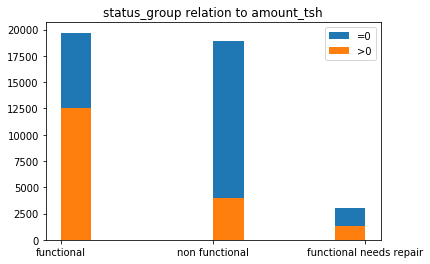

In [29]:
plt.hist(test['status_group'],label='=0')
plt.hist(test1['status_group'], label='>0')
plt.legend()
plt.title('status_group relation to amount_tsh')

Text(0.5, 1.0, 'status_group relation with increasing amount_tsh')

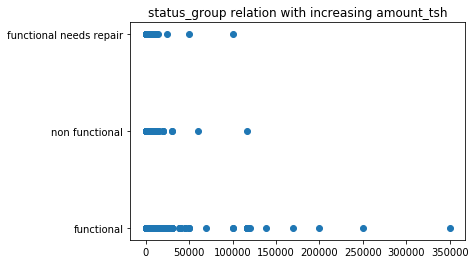

In [30]:
plt.scatter(y=test1['status_group'], x=test1['amount_tsh'])
plt.title('status_group relation with increasing amount_tsh')

## Looking at the extraction type columns

The three columns seem a little redundant. We'll keep the most detailed column and drop the other 2

In [31]:
comparison_column = np.where(Full_data["extraction_type_group"] == Full_data["extraction_type"], 0, 1)
comparison_column.sum()

2469

In [32]:
comparison_column2 = np.where(Full_data["extraction_type_group"] == Full_data["extraction_type_class"], 0, 1)
comparison_column2.sum()

19443

In [33]:
Full_data[Full_data['extraction_type'] != Full_data['extraction_type_group']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
31,6696,50.0,2011-03,Private Individual,180,WU,38.363555,-6.636104,Kituo Cha Maziwa,0,Wami / Ruvu,Kudipera,Pwani,6,1,Bagamoyo,Chalinze,150,False,GeoData Consultants Ltd,WUA,Chalinze wate,True,2004,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
45,12958,0.0,2012-10,World Vision,0,World Vision,33.345260,-3.838998,Shimasa,0,Internal,Isenegeja,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,WUG,SHIMASA,True,0,windmill,wind-powered,wind-powered,wug,user-group,pay when scheme fails,on failure,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
66,34255,0.0,2011-02,Piusi,1788,SHIPO,34.897257,-9.203522,Kwa Piusi,0,Rufiji,Mahalule,Iringa,11,4,Njombe,Ikuka,50,True,GeoData Consultants Ltd,Private operator,NaN,True,2010,other - rope pump,rope pump,rope pump,private operator,commercial,never pay,never pay,soft,good,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump,functional
88,27312,50.0,2011-03,Private Individual,159,WU,38.353567,-6.638696,Kessy,0,Wami / Ruvu,Magwila,Pwani,6,1,Bagamoyo,Chalinze,20,False,GeoData Consultants Ltd,WUA,Chalinze wate,True,2008,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional
92,39920,200.0,2011-03,Danida,18,DA,38.890402,-6.557903,Gedebu,0,Wami / Ruvu,Shule,Pwani,6,1,Bagamoyo,Kiromo,40,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,1987,ksb,submersible,submersible,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,45357,0.0,2013-12,Sangea District Council,847,Sangea District Coun,35.798121,-10.725160,Kwa Inglibeth,0,Ruvuma / Southern Coast,Nanyimbo B,Ruvuma,10,2,Songea Rural,Matimira,0,True,GeoData Consultants Ltd,VWC,NaN,True,2002,other - rope pump,rope pump,rope pump,vwc,user-group,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
59309,50703,50.0,2013-01,Makonde,465,Makonde,39.423152,-10.873742,Mwinyi,0,Ruvuma / Southern Coast,Mwinyi,Mtwara,9,4,Tandahimba,Mahuta,860,True,GeoData Consultants Ltd,Water Board,Mahuta,True,1972,ksb,submersible,submersible,water board,user-group,pay per bucket,per bucket,soft,good,seasonal,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59325,52830,50.0,2011-03,Private Individual,182,WU,38.373661,-6.638756,Ballongo,0,Wami / Ruvu,Milalazi,Pwani,6,1,Bagamoyo,Chalinze,40,False,GeoData Consultants Ltd,WUA,Chalinze wate,True,2006,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59354,16666,0.0,2011-07,Md,0,DW,31.547474,-1.798378,Kwenye Chama Ch,0,Lake Victoria,Kishoju 1,Kagera,18,3,Muleba,Nshamba,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,ksb,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


In [34]:
Full_data[Full_data['extraction_type_group'] != Full_data['extraction_type_class']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
6,19816,0.0,2012-10,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,None,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,None,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
11,50409,200.0,2013-02,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,0,Lake Nyasa,Ngondombwito,Ruvuma,10,5,Namtumbo,Msindo,250,True,GeoData Consultants Ltd,WUG,NaN,False,1987,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59389,30410,0.0,2011-08,Co,783,DWE,30.646486,-7.365418,Sekondari,0,Lake Tanganyika,Itete B,Rukwa,15,3,Nkasi,Kirando,1500,False,GeoData Consultants Ltd,VWC,NaN,False,2009,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59390,13677,0.0,2011-08,Rudep,1715,DWE,31.370848,-8.258160,Kwa Mzee Atanas,0,Lake Tanganyika,Kitonto,Rukwa,15,2,Sumbawanga Rural,Mkowe,150,True,GeoData Consultants Ltd,VWC,NaN,False,1991,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59397,37057,0.0,2011-04,Unknown,0,Unknown,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [35]:
Full_data[Full_data['extraction_type'] != Full_data['extraction_type_class']]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
6,19816,0.0,2012-10,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,None,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,None,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
11,50409,200.0,2013-02,Danida,1062,DANIDA,35.770258,-10.574175,Kwa Alid Nchimbi,0,Lake Nyasa,Ngondombwito,Ruvuma,10,5,Namtumbo,Msindo,250,True,GeoData Consultants Ltd,WUG,NaN,False,1987,swn 80,swn 80,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59389,30410,0.0,2011-08,Co,783,DWE,30.646486,-7.365418,Sekondari,0,Lake Tanganyika,Itete B,Rukwa,15,3,Nkasi,Kirando,1500,False,GeoData Consultants Ltd,VWC,NaN,False,2009,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59390,13677,0.0,2011-08,Rudep,1715,DWE,31.370848,-8.258160,Kwa Mzee Atanas,0,Lake Tanganyika,Kitonto,Rukwa,15,2,Sumbawanga Rural,Mkowe,150,True,GeoData Consultants Ltd,VWC,NaN,False,1991,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59397,37057,0.0,2011-04,Unknown,0,Unknown,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [36]:
# dropping id column
Full_data.drop(columns=['id'], axis=1, inplace=True)

# dropping 2 out of the 3 extraction type columns, they seem redundant
Full_data.drop(columns=['extraction_type_class','extraction_type_group'], axis=1, inplace=True)


## Looking at funder

Grouping all funders that fund 10 or less wells as small_funder reduces the overall amount of different categories significantly

In [37]:
Full_data.funder.value_counts()

Government Of Tanzania    9084
Unknown                   3639
Danida                    3114
Hesawa                    2202
Rwssp                     1374
                          ... 
Legeza Legeza                1
Namungo Miners               1
Noshadi                      1
Daida                        1
Sumriy                       1
Name: funder, Length: 1897, dtype: int64

In [38]:
test3 = Full_data
test3.loc[test3['funder'].value_counts()[test3['funder']].values < 11, 'funder'] = "small_funder"
test3.funder.nunique()

393

In [39]:
Full_data.loc[Full_data['funder'].value_counts()[Full_data['funder']].values < 11, 'funder'] = "small_funder"

In [40]:
Full_data.funder.value_counts()

Government Of Tanzania            9084
Unknown                           3639
small_funder                      3147
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  777
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                      

## Looking at GPS height

Keeping GPS as is, the data looks good

In [41]:
Full_data.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [42]:
Full_data.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

Text(0, 0.5, 'GPS Height')

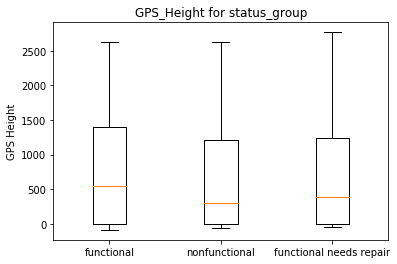

In [43]:
functional_group = Full_data[Full_data['status_group'] == 'functional']['gps_height']
nonfunctional_group = Full_data[Full_data['status_group'] == 'non functional']['gps_height']
functional_needs_repair_group = Full_data[Full_data['status_group'] == 'functional needs repair']['gps_height']
grouped = [functional_group,nonfunctional_group,functional_needs_repair_group]
plt.boxplot(grouped, labels=['functional','nonfunctional','functional needs repair'])
plt.title('GPS_Height for status_group')
plt.ylabel('GPS Height')

## Looking at Installer

Installer has 1800 installers that have done 10 or less installs. Going to group installes with 10 or less as 'small_installers'

In [44]:
Full_data.installer.value_counts()

DWE                 17402
Unknown              3658
Government           1825
RWE                  1206
Commu                1060
                    ...  
Christina Magoge        1
ACTION AID              1
Al Ha                   1
Mwamama                 1
Mwita Mahiti            1
Name: installer, Length: 2145, dtype: int64

In [45]:
test4 = Full_data
test4.loc[test4['installer'].value_counts()[test4['installer']].values < 11, 'installer'] = "small_installer"
test4.installer.nunique()

395

In [46]:
test4.installer.value_counts()

DWE                              17402
small_installer                   3830
Unknown                           3658
Government                        1825
RWE                               1206
Commu                             1060
DANIDA                            1050
KKKT                               898
Hesawa                             840
0                                  777
TCRS                               707
Central government                 622
CES                                610
Community                          553
DANID                              552
District Council                   551
HESAWA                             539
LGA                                408
World vision                       408
WEDECO                             397
TASAF                              396
District council                   392
Gover                              383
AMREF                              329
TWESA                              316
WU                       

## Looking at Longitude and Latitude

There is some outliers for this data. There is 1,812 wells that have 0 for longitude, need to drop those since we do not know where they are located. It's not that many wells in the grand scheme of the dataset.

In [47]:
functional_group_df = Full_data[Full_data['status_group'] == 'functional']
nonfunctional_group_df = Full_data[Full_data['status_group'] == 'non functional']
functional_needs_repair_group_df = Full_data[Full_data['status_group'] == 'functional needs repair']

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


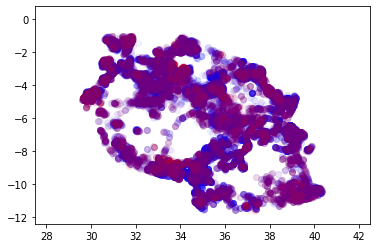

In [48]:
fig1, ax1 = plt.subplots()

ax1.scatter(functional_group_df['longitude'],functional_group_df['latitude'],c='blue',alpha=0.05)
ax1.scatter(functional_needs_repair_group_df['longitude'],functional_needs_repair_group_df['latitude'],c='red',alpha=0.05)
ax1.scatter(nonfunctional_group_df['longitude'],nonfunctional_group_df['latitude'],c='purple',alpha=0.05)

ax1.set_xlim(left=27.5,right=42.5)
fig1.show()

In [49]:
len(Full_data[Full_data['longitude']==0])

1812

In [50]:
Full_data.drop(Full_data.loc[Full_data['longitude']==0].index, inplace=True)
len(Full_data[Full_data['longitude']==0])

0

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


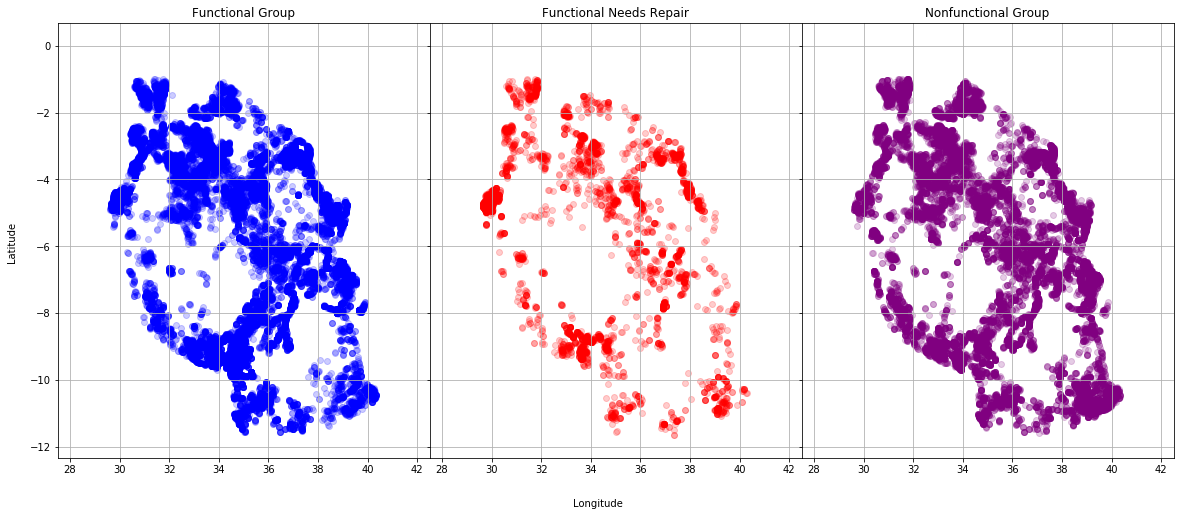

In [51]:
fig2, (ax2,ax3,ax4) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(20,8))

ax2.scatter(functional_group_df['longitude'],functional_group_df['latitude'],
            alpha=0.2,c='blue')
ax3.scatter(functional_needs_repair_group_df['longitude'],functional_needs_repair_group_df['latitude'],c='red',alpha=0.2)
ax4.scatter(nonfunctional_group_df['longitude'],nonfunctional_group_df['latitude'],c='purple',alpha=0.2)

ax2.set_xlim(left=27.5,right=42.5)
ax3.set_xlim(left=27.5,right=42.5)
ax4.set_xlim(left=27.5,right=42.5)

ax2.title.set_text('Functional Group')
ax3.title.set_text('Functional Needs Repair')
ax4.title.set_text('Nonfunctional Group')

ax2.grid()
ax3.grid()
ax4.grid()

fig2.text(0.5, 0.04, 'Longitude', ha='center')
fig2.text(0.09, 0.5, 'Latitude', va='center', rotation='vertical')

fig2.subplots_adjust(wspace=0)
fig2.show()

## Looking at wpt_name

Majority of the wpt_name seems to have a bunch of small groups, the highest one only has 1,734. Going to drop the whole column.

In [52]:
Full_data.wpt_name.value_counts()

none                  3492
Shuleni               1734
Zahanati               814
Msikitini              533
Kanisani               322
                      ... 
Gumbu_Kati               1
Patson Mwashigunda       1
Kwa Rabi                 1
Kwa Salanga              1
Kwa Doritha              1
Name: wpt_name, Length: 36720, dtype: int64

In [53]:
test5 = Full_data
test5.loc[test5['wpt_name'].value_counts()[test5['wpt_name']].values < 11, 'wpt_name'] = "not_well_known"
test5.wpt_name.nunique()

217

In [54]:
Full_data.drop(columns=['wpt_name'],inplace=True)

## Looking at num_private

Not really sure what this column is about, there is 65 different numbers. Might be valuable, just going to make it into a categorical column.

In [55]:
Full_data.num_private.nunique()

65

In [56]:
print(functional_group_df.num_private.nunique())
print(functional_needs_repair_group_df.num_private.nunique())
print(nonfunctional_group_df.num_private.nunique())

55
18
40


In [57]:
functional_group_df.num_private.value_counts()

0       31798
6          55
1          40
32         39
8          31
5          31
15         27
45         26
93         21
7          15
2          14
102        14
3          12
47         12
65         11
17         10
4           9
39          8
41          7
25          6
16          6
11          5
120         5
24          5
22          5
10          4
58          4
12          4
20          4
9           3
34          3
26          2
668         1
61          1
672         1
141         1
14          1
60          1
240         1
80          1
94          1
450         1
180         1
35          1
131         1
755         1
27          1
38          1
1402        1
150         1
698         1
23          1
136         1
280         1
111         1
Name: num_private, dtype: int64

In [58]:
nonfunctional_group_df.num_private.value_counts()

0       22576
1          27
39         22
6          20
5          15
80         14
3          12
65         11
4          11
7          10
45          9
2           9
20          9
47          8
34          7
8           7
102         6
11          6
25          5
150         5
50          5
15          4
17          3
38          3
41          3
14          2
120         2
42          1
12          1
213         1
22          1
300         1
93          1
9           1
87          1
1776        1
62          1
32          1
16          1
27          1
Name: num_private, dtype: int64

In [59]:
functional_needs_repair_group_df.num_private.value_counts()

0      4269
8         8
1         6
6         6
93        6
15        4
17        4
3         3
61        2
16        1
20        1
160       1
55        1
25        1
47        1
30        1
7         1
45        1
Name: num_private, dtype: int64

In [60]:
Full_data['num_private'] = Full_data.num_private.astype('category')

## Looking at basin

Basin data looks good.

In [61]:
Full_data.basin.value_counts()

Pangani                    8940
Lake Victoria              8535
Rufiji                     7976
Internal                   7785
Lake Tanganyika            6333
Wami / Ruvu                5987
Lake Nyasa                 5085
Ruvuma / Southern Coast    4493
Lake Rukwa                 2454
Name: basin, dtype: int64

## Looking at subvillage

There is 18,568 different subvillages. Doing 10 or less subvillage counts brings it down to 598. But the majority is less than 10, so too many categories. Might be best to just drop this column.

In [62]:
Full_data.subvillage.value_counts()

Majengo       494
Shuleni       492
Madukani      435
None          371
Kati          366
             ... 
Bwilinde B      1
Masasi A        1
Kitege          1
Nambarapi       1
Nyamajiwa       1
Name: subvillage, Length: 18568, dtype: int64

In [63]:
test6 = Full_data
test6.loc[test6['subvillage'].value_counts()[test6['subvillage']].values < 11, 'subvillage'] = "small_village"
test6.subvillage.nunique()

598

In [64]:
test6.subvillage.value_counts()

small_village    40640
Majengo            494
Shuleni            492
Madukani           435
None               371
                 ...  
Karoleni            11
Arudeko             11
Kyimo               11
Shabayanda          11
Mtunge              11
Name: subvillage, Length: 598, dtype: int64

## Looking at region, region_code, district code, lga, and ward

The data looks similar, the region code seems to have more categories. Going to drop region_code, district code, and ward. Keeping region and lga.

In [65]:
Full_data.region.nunique()

21

In [66]:
Full_data.region_code.nunique()

27

In [67]:
Full_data.district_code.nunique()

20

In [68]:
Full_data.region.value_counts()

Iringa           5294
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Shinyanga        3977
Arusha           3350
Kagera           3316
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Mwanza           2295
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [69]:
len(Full_data.lga.value_counts())

124

In [70]:
len(Full_data.ward.value_counts())

2033

(array([6370., 4386., 4252., 4560., 3086., 3319., 2828., 1503., 1049.,
         906.]),
 array([  0. ,  12.3,  24.6,  36.9,  49.2,  61.5,  73.8,  86.1,  98.4,
        110.7, 123. ]),
 <a list of 10 Patch objects>)

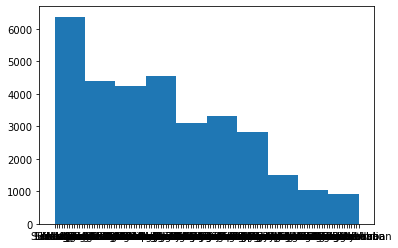

In [71]:
plt.hist(functional_group_df['lga'])

(array([ 995.,  715., 1146.,  460.,  326.,  317.,  138.,  107.,   81.,
          32.]),
 array([  0. ,  10.6,  21.2,  31.8,  42.4,  53. ,  63.6,  74.2,  84.8,
         95.4, 106. ]),
 <a list of 10 Patch objects>)

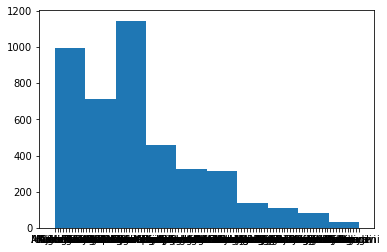

In [72]:
plt.hist(functional_needs_repair_group_df['lga'])

(array([3757., 2672., 2141., 2629., 2204., 2527., 2025., 2382., 1737.,
         750.]),
 array([  0. ,  12.4,  24.8,  37.2,  49.6,  62. ,  74.4,  86.8,  99.2,
        111.6, 124. ]),
 <a list of 10 Patch objects>)

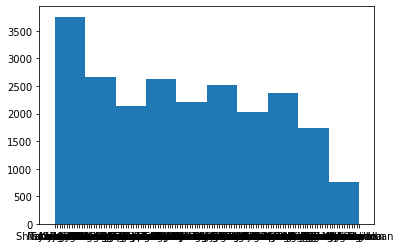

In [73]:
plt.hist(nonfunctional_group_df['lga'])

In [74]:
Full_data.drop(columns=['region_code','district_code','ward'],axis=1,inplace=True)

## Looking at population

There is some 0 for population but that might be important too so keeping that. Don't think we need to change anything to it.

Text(0.5, 1.0, 'status_group relation with increasing population')

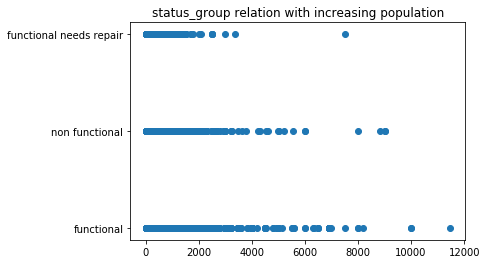

In [75]:
plt.scatter(y=test1['status_group'], x=test1['population'])
plt.title('status_group relation with increasing population')

In [76]:
Full_data_1.population.sum()

10686653

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe6d09a6a58>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe6d09b4128>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe6d09a64a8>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe6d09b47b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe6d09b4b00>,
 'means': []}

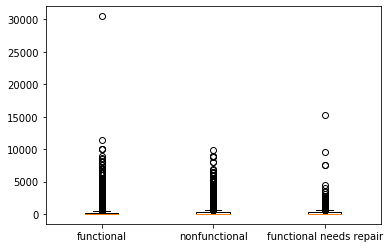

In [77]:
functional_group_pop = Full_data[Full_data['status_group'] == 'functional']['population']
nonfunctional_group_pop = Full_data[Full_data['status_group'] == 'non functional']['population']
functional_needs_repair_group_pop = Full_data[Full_data['status_group'] == 'functional needs repair']['population']
grouped_pop = [functional_group_pop,nonfunctional_group_pop,functional_needs_repair_group_pop]
plt.boxplot(grouped_pop, labels=['functional','nonfunctional','functional needs repair'])

In [78]:
functional_group_pop.mean()

192.75166459587754

In [79]:
nonfunctional_group_pop.mean()

174.26149631758577

In [80]:
functional_needs_repair_group_pop.mean()

192.29610786059527

## Looking at Public Meeting

Public meeting looks good, going to do KNN imputation on unknown.

In [81]:
Full_data.public_meeting.value_counts()

True       49737
False       4875
Unknown     2976
Name: public_meeting, dtype: int64

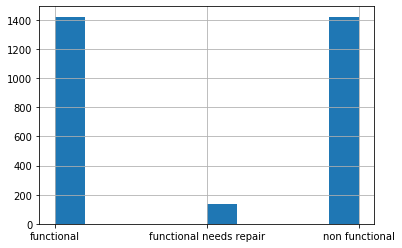

In [82]:
test7 = Full_data[Full_data['public_meeting'] == 'Unknown']
test7.status_group.hist()

## Looking at recorded_by

This column only has one category, going to drop it.

In [83]:
Full_data.recorded_by.value_counts()

GeoData Consultants Ltd    57588
Name: recorded_by, dtype: int64

In [84]:
Full_data.shape

(57588, 34)

## Looking at scheme_management and scheme_name

Scheme_management looks good, None is just a placeholder for NA. NA will be addressed using KNN imputation. Scheme_name will be dropped, they add too many category values and don't give a better insite than scheme_management.

In [85]:
Full_data.scheme_management.value_counts()

VWC                 36143
WUG                  4249
None                 3751
Water authority      3151
WUA                  2882
Water Board          2747
Parastatal           1607
Private operator     1063
Company              1061
Other                 765
SWC                    97
Trust                  72
Name: scheme_management, dtype: int64

Text(0.5, 1.0, 'status_group relation with scheme_management')

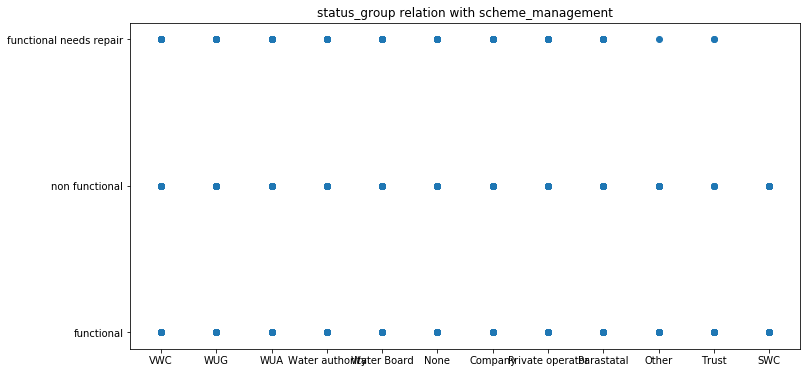

In [86]:
# There's probably a better graph for this but this is just a quick look.
plt.figure(figsize=(12,6))
plt.scatter(y=test1['status_group'], x=test1['scheme_management'])
plt.title('status_group relation with scheme_management')

In [87]:
Full_data.scheme_name.value_counts()

K                                      682
None                                   644
Borehole                               418
Chalinze wate                          405
M                                      400
                                      ... 
Mwamanoni village water pipe scheme      1
Kayugi spring source                     1
Loca                                     1
Wisi                                     1
ISANJU WATER SCHEME                      1
Name: scheme_name, Length: 2658, dtype: int64

In [88]:
Full_data.drop(columns=['scheme_name'],axis=1,inplace=True)

## Looking at Permit

This column is addressed in checking Nan entries (3.2)

In [89]:
Full_data.permit.value_counts()

True     38100
False    19488
Name: permit, dtype: int64

## Looking at construction_year

Making an Age column instead of construction_year would be better. There is 18,897 0's, these we can put as 'unknown'. Also going to put this column as a category since we have a bunch of unknowns. This will be 55 columns.

In [90]:
Full_data.construction_year.value_counts()

0       18897
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [91]:
Full_data['Age'] = [2020 - x for x in Full_data['construction_year']]
Full_data['Age'].replace({2020:'Unknown'},inplace=True)
Full_data['Age'] = Full_data.Age.astype('category')
Full_data.drop(columns=['construction_year'],axis=1,inplace=True)

In [92]:
Full_data.Age.nunique()

55

## Looking at management and management_group

Both these columns describe how the well is managed. Can probably bring this down to one column. Just from initial look the management might be better to keep. Both columns don't seem to show any apparent trend but management has a bigger spread meaning it could potentially tell us more. So going to drop management_group.

In [93]:
Full_data.management.value_counts()

vwc                 39746
wug                  5556
water board          2932
wua                  2533
private operator     1970
parastatal           1696
water authority       902
other                 840
company               685
unknown               551
other - school         99
trust                  78
Name: management, dtype: int64

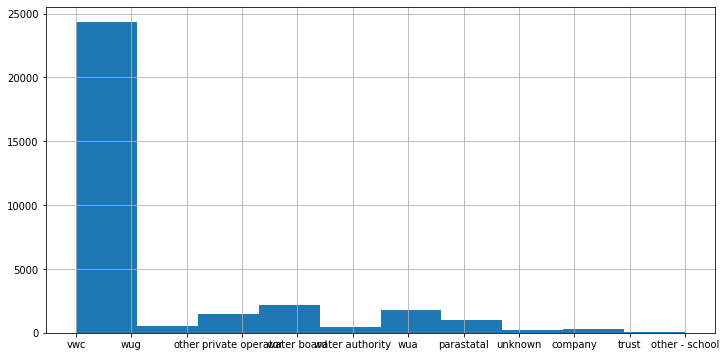

In [94]:
functional_group_df.management.hist(figsize=(12,6))

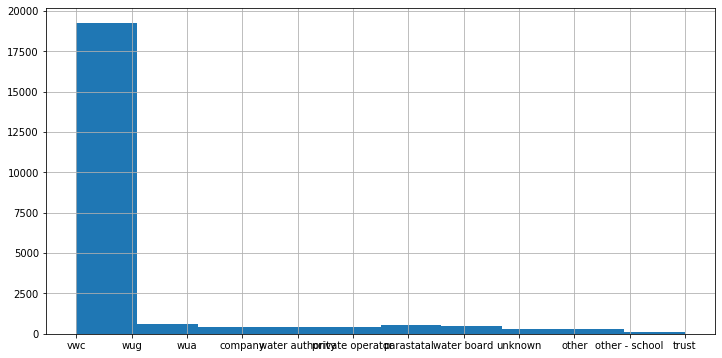

In [95]:
nonfunctional_group_df.management.hist(figsize=(12,6))

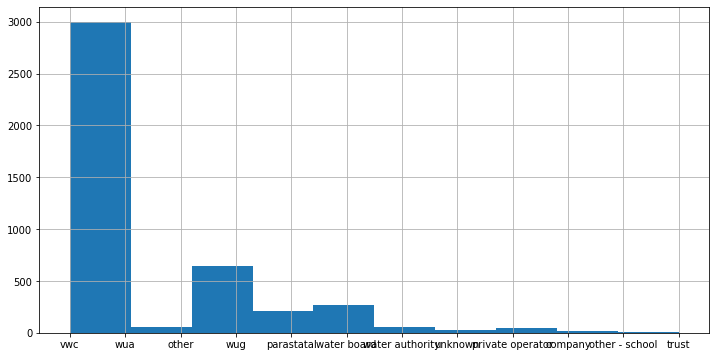

In [96]:
functional_needs_repair_group_df.management.hist(figsize=(12,6))

In [97]:
Full_data.management_group.value_counts()

user-group    50767
commercial     3635
parastatal     1696
other           939
unknown         551
Name: management_group, dtype: int64

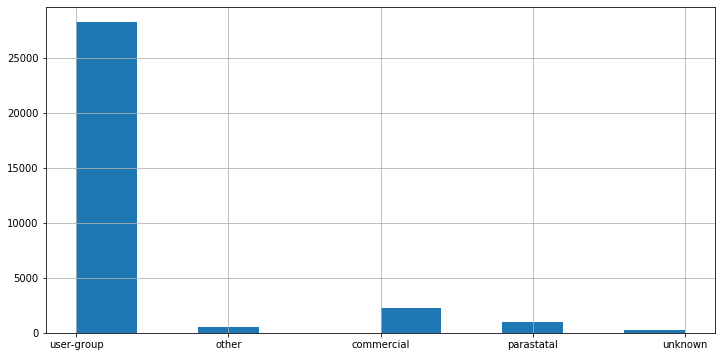

In [98]:
functional_group_df.management_group.hist(figsize=(12,6))

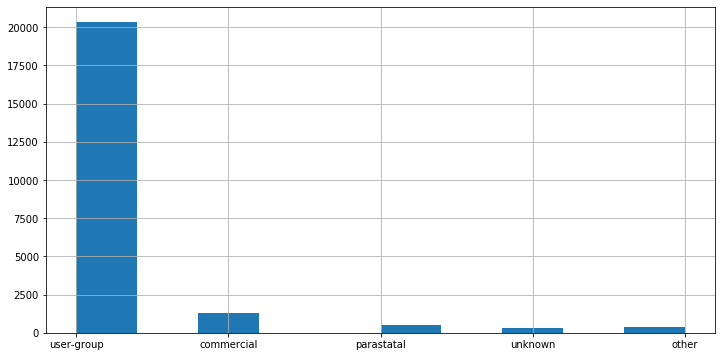

In [99]:
nonfunctional_group_df.management_group.hist(figsize=(12,6))

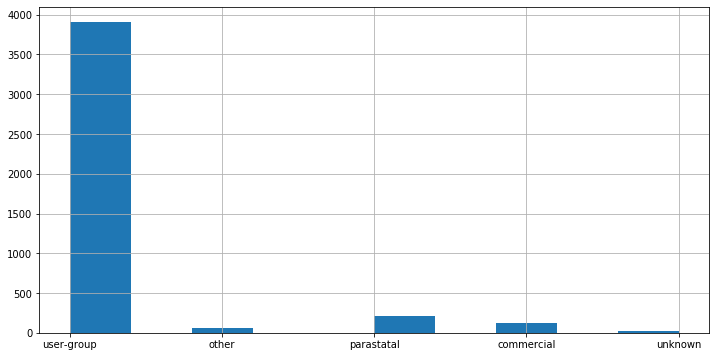

In [100]:
functional_needs_repair_group_df.management_group.hist(figsize=(12,6))

In [101]:
Full_data.drop(columns=['management_group'],axis=1,inplace=True)

## Looking at payment and payment_type

These columns look like they're the same info. It also looks like the data is the same in both columns. Going to drop payment and keep payment type.

In [102]:
Full_data.payment.value_counts()

never pay                24380
pay per bucket            8953
pay monthly               8229
unknown                   7654
pay when scheme fails     3843
pay annually              3626
other                      903
Name: payment, dtype: int64

In [103]:
Full_data.payment_type.value_counts()

never pay     24380
per bucket     8953
monthly        8229
unknown        7654
on failure     3843
annually       3626
other           903
Name: payment_type, dtype: int64

In [104]:
Full_data.drop(columns=['payment'],axis=1,inplace=True)

## Looking at water_quality and quality group

These columns look at water quality. The data looks basically the same. The water_quality data is a little more discriptive so going to keep that and drop the quality_group.

In [105]:
Full_data.water_quality.value_counts()

soft                  49431
salty                  4772
unknown                1661
milky                   803
coloured                479
salty abandoned         228
fluoride                199
fluoride abandoned       15
Name: water_quality, dtype: int64

In [106]:
Full_data.quality_group.value_counts()

good        49431
salty        5000
unknown      1661
milky         803
colored       479
fluoride      214
Name: quality_group, dtype: int64

In [107]:
Full_data[Full_data['quality_group'] == 'salty']['status_group'].value_counts()

non functional             2467
functional                 2319
functional needs repair     214
Name: status_group, dtype: int64

In [108]:
Full_data[Full_data['water_quality'] == 'salty abandoned']['status_group'].value_counts()

functional                 126
non functional              87
functional needs repair     15
Name: status_group, dtype: int64

In [109]:
Full_data[Full_data['water_quality']=='fluoride']['status_group'].value_counts()

functional                 150
non functional              36
functional needs repair     13
Name: status_group, dtype: int64

In [110]:
Full_data[Full_data['water_quality']=='fluoride abandoned']['status_group'].value_counts()

non functional    11
functional         4
Name: status_group, dtype: int64

In [111]:
Full_data.drop(columns=['quality_group'],axis=1,inplace=True)

## Looking at quantity and quantity group

These columns look at the quantity of water at the wells. They're both the same so going to drop quantity_group and keeping quantity.

In [112]:
Full_data.quantity.value_counts()

enough          32260
insufficient    14564
dry              5990
seasonal         4001
unknown           773
Name: quantity, dtype: int64

In [113]:
Full_data.quantity_group.value_counts()

enough          32260
insufficient    14564
dry              5990
seasonal         4001
unknown           773
Name: quantity_group, dtype: int64

In [114]:
Full_data.drop(columns=['quantity_group'],axis=1,inplace=True)

## Looking at source, source_type and source_class

These columns look at the source of the water for the wells. Going to keep source since it gives a little more insight and dropping source_type. Also going to keep source_class since it will only add 3 categories and might help.

In [115]:
Full_data.source.value_counts()

spring                  17006
shallow well            15499
machine dbh             10826
river                    9612
rainwater harvesting     2218
hand dtw                  873
dam                       649
lake                      639
other                     202
unknown                    64
Name: source, dtype: int64

In [116]:
Full_data.source_type.value_counts()

spring                  17006
shallow well            15499
borehole                11699
river/lake              10251
rainwater harvesting     2218
dam                       649
other                     266
Name: source_type, dtype: int64

In [117]:
print(Full_data[Full_data['source']=='lake']['status_group'].value_counts(normalize=True))
print(Full_data[Full_data['source_type']=='river/lake']['status_group'].value_counts(normalize=True))


non functional             0.769953
functional                 0.211268
functional needs repair    0.018779
Name: status_group, dtype: float64
functional                 0.546288
non functional             0.333431
functional needs repair    0.120281
Name: status_group, dtype: float64


In [118]:
Full_data.source_class.value_counts()

groundwater    44204
surface        13118
unknown          266
Name: source_class, dtype: int64

In [119]:
print(Full_data[Full_data['source_class']=='groundwater']['status_group'].value_counts(normalize=True))
print(Full_data[Full_data['source_class']=='surface']['status_group'].value_counts(normalize=True))

functional                 0.543887
non functional             0.402407
functional needs repair    0.053706
Name: status_group, dtype: float64
functional                 0.548026
non functional             0.333664
functional needs repair    0.118311
Name: status_group, dtype: float64


In [120]:
Full_data.drop(columns=['source_type'],axis=1,inplace=True)

## Looking at waterpoint_type and waterpoint_type_group

These columns look at the kind of waterpoint. The only difference between the two looks like one separates communal standpipe to communal standpipe/communal standpipe multiple. The status group difference between what are in 'communal standpipe' and 'communal standpipe multiple' looks significant so going to keep waterpoint_type and dropping waterpoint_type_group.

In [121]:
Full_data.waterpoint_type.value_counts()

communal standpipe             28375
hand pump                      16181
other                           6167
communal standpipe multiple     5959
improved spring                  783
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [122]:
Full_data.waterpoint_type_group.value_counts()

communal standpipe    34334
hand pump             16181
other                  6167
improved spring         783
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [123]:
print(Full_data[Full_data['waterpoint_type']=='communal standpipe']['status_group'].value_counts(normalize=True))
print(Full_data[Full_data['waterpoint_type']=='communal standpipe multiple']['status_group'].value_counts(normalize=True))

functional                 0.621921
non functional             0.299101
functional needs repair    0.078978
Name: status_group, dtype: float64
non functional             0.520222
functional                 0.371035
functional needs repair    0.108743
Name: status_group, dtype: float64


In [124]:
Full_data.drop(columns=['waterpoint_type_group'],axis=1,inplace=True)

# Preprocessing and Train/Test Split

These are the "fixes" we're gonna do to the data

In [125]:
# creating preprocessed dataset
df_preprocessed = pd.merge(X_data, y_data, left_on='id', right_on='id')

# Switching all Nan's to Missing
df_preprocessed[['funder', 'installer', 'public_meeting', 'scheme_management']] = df_preprocessed[['funder', 'installer',
                                                                                                   'public_meeting', 'scheme_management']].fillna(value='Missing')

# Need to add 'small_funder' to funders that fund 10 or less
df_preprocessed.loc[df_preprocessed['funder'].value_counts(
)[df_preprocessed['funder']].values < 11, 'funder'] = 'small_funder'

# Need to add 'small_installer' to installers that fund 10 or less
df_preprocessed.loc[df_preprocessed['installer'].value_counts(
)[df_preprocessed['installer']].values < 11, 'installer'] = 'small_installer'


# Changing nan values in permit to false
df_preprocessed[['permit']] = df_preprocessed[['permit']].fillna(value=False)

# dropping id, subvillage, scheme_name, wpt_name, region_code, district_code, ward
df_preprocessed.drop(columns=['id', 'subvillage', 'scheme_name', 'wpt_name',
                              'region_code', 'district_code', 'ward', 'recorded_by'], axis=1, inplace=True)

# dropping 2 out of the 3 extraction type columns, they seem redundant
df_preprocessed.drop(
    columns=['extraction_type_class', 'extraction_type_group'], axis=1, inplace=True)

# dropping 1,812 wells that we do not have logitude coordinates on
df_preprocessed.drop(
    df_preprocessed.loc[df_preprocessed['longitude'] == 0].index, inplace=True)

# Changing num_private to category data type
df_preprocessed['num_private'] = df_preprocessed.num_private.astype('category')

# Making an Age column instead of construction_year.
# There is 18,897 0's, these we can put as 'unknown'.
# Also going to put this column as a category since we have a bunch of unknowns.
df_preprocessed['Age'] = [
    2020 - x for x in df_preprocessed['construction_year']]
df_preprocessed['Age'].replace({2020: 'Unknown'}, inplace=True)
df_preprocessed['Age'] = df_preprocessed.Age.astype('category')
df_preprocessed.drop(columns=['construction_year'], axis=1, inplace=True)

# Dropping management_group, payment, quality_group, quantity_group,
# waterpoint_type_group and source_type
df_preprocessed.drop(columns=['management_group', 'payment', 'quality_group',
                              'quantity_group', 'source_type', 'waterpoint_type_group'], axis=1, inplace=True)

# Changing date recorded to just year/month to bring down the number of categories
df_preprocessed['date_recorded'] = [x[0:7] for x in df_preprocessed['date_recorded']]

# Change permit to a category for the column
df_preprocessed['permit'] = df_preprocessed.num_private.astype('category')

# Creating dummy categories
cat_col = list(df_preprocessed.columns)
non_cat_col = ['amount_tsh','gps_height','longitude','latitude','population','status_group']
cat_col = [e for e in cat_col if e not in non_cat_col]
df_dummies = pd.get_dummies(df_preprocessed[cat_col],drop_first=True)
df_preprocessed.drop(cat_col,axis=1,inplace=True)
df = pd.concat([df_preprocessed,df_dummies],axis=1)

# Both installer and funder have 777 '0', seems kind of suspicious both have the same amount.
# 0 might actually be a group so going to leave that in but might be something to optimize later

# Might be good to look into doing KNN imputation on the 0 values in amount_tsh


In [126]:
df.shape

(57588, 1237)

Now to do train-test split on data

In [127]:
# Assigning data to variables
y = df['status_group']
X = df.drop(columns=['status_group'],axis=1)
y = y.replace({'functional':0,'functional needs repair':1,'non functional':2})

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=22)

# Dealing with class imbalance, using SMOTE

In [129]:
y_train.value_counts()

0    23561
2    16671
1     2959
Name: status_group, dtype: int64

In [130]:
oversample = SMOTE()
X_train_smoted, y_train_smoted = oversample.fit_resample(X_train, y_train)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [131]:
columnnames = X.columns

In [132]:
X_train_smoted = pd.DataFrame(X_train_smoted)
X_train_smoted.columns = list(columnnames)
y_train_smoted = pd.Series(y_train_smoted)

In [133]:
y_train_smoted.value_counts()

2    23561
1    23561
0    23561
dtype: int64

In [134]:
y_train.value_counts()

0    23561
2    16671
1     2959
Name: status_group, dtype: int64

# Inital modeling

Now that the data is cleaned and balanced it's time to try modeling.

List of models to try:
- Dummy classifier
- Logistic Regression
- KNN
- Naive Bayes
- Decision Trees
- Random Forest
- XG Boost
- SVM

## Dummy classifier

In [135]:
dummyclf = DummyClassifier()
dummyclf.fit(X_train_smoted,y_train_smoted)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


DummyClassifier()

Training Precision:  0.3352931537835037
Testing Precision:  0.3247193034119024



Training Recall:  0.3352998599380332
Testing Recall:  0.3222321809424018



Training Accuracy:  0.3352998599380332
Testing Accuracy:  0.3257623115926929



Training F1-Score:  0.3352935233302947
Testing F1-Score:  0.287338119971513



              precision    recall  f1-score   support

           0       0.53      0.33      0.40      7828
           1       0.06      0.31      0.11       972
           2       0.38      0.33      0.35      5597

    accuracy                           0.33     14397
   macro avg       0.32      0.32      0.29     14397
weighted avg       0.44      0.33      0.36     14397



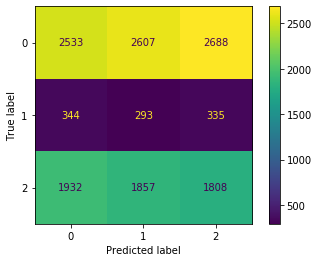

In [136]:
eval_model(dummyclf, X_train_smoted, y_train_smoted, X_test, y_test)

## Logisitic Regression

In [137]:
# Need to min max scale data before using
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train,y_train)
X_test_scaled = scaler.transform(X_test)

In [138]:
logreg = LogisticRegression(fit_intercept=False, solver='saga')
logreg.fit(X_train_scaled,y_train)

LogisticRegression(fit_intercept=False, solver='saga')

Training Precision:  0.7171159219415819
Testing Precision:  0.69921892822527



Training Recall:  0.5890956001101743
Testing Recall:  0.5754305037752081



Training Accuracy:  0.7759255400430646
Testing Accuracy:  0.765645620615406



Training F1-Score:  0.6101595412024765
Testing F1-Score:  0.5932729681172169



              precision    recall  f1-score   support

           0       0.75      0.89      0.82      7828
           1       0.55      0.14      0.22       972
           2       0.80      0.70      0.75      5597

    accuracy                           0.77     14397
   macro avg       0.70      0.58      0.59     14397
weighted avg       0.76      0.77      0.75     14397



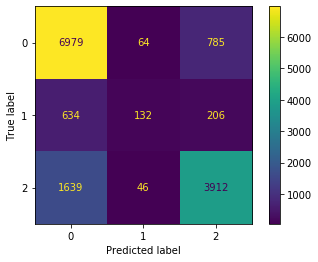

In [139]:
eval_model(logreg,X_train_scaled,y_train,X_test_scaled,y_test)

## KNN 

In [150]:
#Need to standard scaler dataset
StdScaler = StandardScaler()

X_train_stdScaled = StdScaler.fit_transform(X_train)
X_test_stdScaled = StdScaler.transform(X_test)

In [151]:
#Modeling
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train_stdScaled,y_train)

KNeighborsClassifier()

Training Precision:  0.7703809997490302
Testing Precision:  0.6525810975315366



Training Recall:  0.6891371013004077
Testing Recall:  0.6007624756491138



Training Accuracy:  0.8165821583200203
Testing Accuracy:  0.744530110439675



Training F1-Score:  0.7176466139234375
Testing F1-Score:  0.6184652189740936



              precision    recall  f1-score   support

           0       0.75      0.84      0.80      7828
           1       0.44      0.27      0.33       972
           2       0.77      0.69      0.72      5597

    accuracy                           0.74     14397
   macro avg       0.65      0.60      0.62     14397
weighted avg       0.74      0.74      0.74     14397



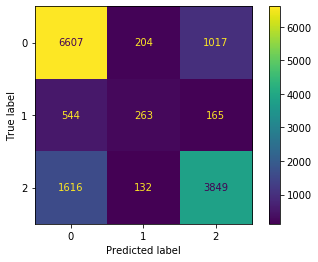

In [152]:
eval_model(KNN_model,X_train_stdScaled,y_train,X_test_stdScaled,y_test)

## Naive Bayes (Need to do)

In [143]:
## This is where Naive Bayes will go, will try later

## Decision Trees

Training Precision:  1.0
Testing Precision:  0.6372785426880115



Training Recall:  1.0
Testing Recall:  0.6372284340104325



Training Accuracy:  1.0
Testing Accuracy:  0.7559908314232132



Training F1-Score:  1.0
Testing F1-Score:  0.6372498587683503



              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7828
           1       0.35      0.35      0.35       972
           2       0.77      0.76      0.77      5597

    accuracy                           0.76     14397
   macro avg       0.64      0.64      0.64     14397
weighted avg       0.76      0.76      0.76     14397



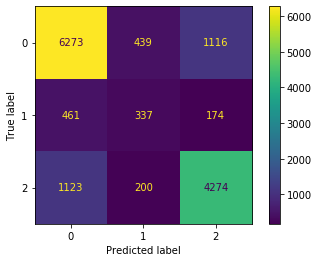

In [144]:
Tree_model = DecisionTreeClassifier(criterion='entropy')

Tree_model.fit(X_train,y_train)
eval_model(Tree_model,X_train,y_train,X_test,y_test)

## Random Forest

Training Precision:  0.9999717070548458
Testing Precision:  0.7124694220284374



Training Recall:  0.9999600103972967
Testing Recall:  0.6645868767272985



Training Accuracy:  0.9999536940566321
Testing Accuracy:  0.8005834548864347



Training F1-Score:  0.9999658569262295
Testing F1-Score:  0.6827016665899531



              precision    recall  f1-score   support

           0       0.81      0.87      0.84      7828
           1       0.51      0.34      0.41       972
           2       0.82      0.78      0.80      5597

    accuracy                           0.80     14397
   macro avg       0.71      0.66      0.68     14397
weighted avg       0.79      0.80      0.80     14397



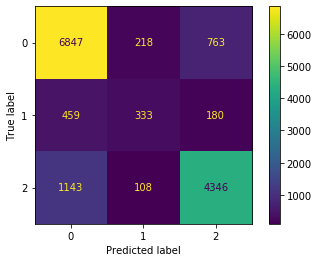

In [145]:
Forest_model = RandomForestClassifier()
Forest_model.fit(X_train,y_train)
eval_model(Forest_model,X_train,y_train,X_test,y_test)

## XG Boost

Training Precision:  0.7222238386245445
Testing Precision:  0.7273509044078952



Training Recall:  0.5500971857961423
Testing Recall:  0.5483814007156993



Training Accuracy:  0.7510129425111713
Testing Accuracy:  0.7480030561922623



Training F1-Score:  0.5675419418340307
Testing F1-Score:  0.5660275014957126



              precision    recall  f1-score   support

           0       0.72      0.93      0.81      7828
           1       0.63      0.11      0.19       972
           2       0.83      0.61      0.70      5597

    accuracy                           0.75     14397
   macro avg       0.73      0.55      0.57     14397
weighted avg       0.76      0.75      0.73     14397



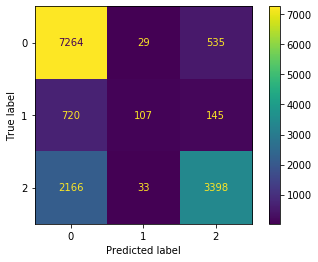

In [147]:
XG_model = xgb.XGBClassifier()
XG_model.fit(X_train,y_train)
eval_model(XG_model,X_train,y_train,X_test,y_test)

## SVM (Need to do)

In [143]:
# We'll test SVM here

## Conclusion for initial modeling

Random Forest has the highest accuracy overall and the best recall on the "non-functional" category. The runner up for overall accuracy is Logistic Regression and for recall is Decision Tree.

In [180]:
initialmodeling = pd.DataFrame()
initialmodeling['Models'] = ['Dummy_Classifier','Logisitic Regression',
                                'KNN','Decision_Tree','RandomForest','XGBoost']
initialmodeling['Overall_Accuracy'] = [0.33,0.77,0.74,0.76,0.80,0.75]
initialmodeling['recall_2'] = [0.33,0.70,0.69,0.76,0.78,0.61]
initialmodeling.set_index('Models')

,Overall_Accuracy,recall_2
Models,,
Dummy_Classifier,0.33,0.33
Logisitic Regression,0.77,0.70
KNN,0.74,0.69
Decision_Tree,0.76,0.76
RandomForest,0.80,0.78
XGBoost,0.75,0.61


# Test for using smoted dataset

Class imbalance affects Random Forest the least but going to see if a smoted dataset will give better results for Random Forest. Also curious to see how XGBoost and Logistic Regression will do on smoted data.

## Random Forest

Training Precision:  0.9999858529270295
Testing Precision:  0.6942097264246088



Training Recall:  0.9999858523265849
Testing Recall:  0.6810721309892901



Training Accuracy:  0.9999858523265849
Testing Accuracy:  0.7959991664930194



Training F1-Score:  0.9999858523265784
Testing F1-Score:  0.6870787947282265



              precision    recall  f1-score   support

           0       0.82      0.86      0.84      7828
           1       0.44      0.41      0.42       972
           2       0.82      0.78      0.80      5597

    accuracy                           0.80     14397
   macro avg       0.69      0.68      0.69     14397
weighted avg       0.79      0.80      0.79     14397



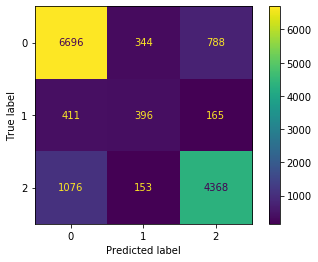

In [155]:
Forest_model_2 = RandomForestClassifier()
Forest_model_2.fit(X_train_smoted,y_train_smoted)
eval_model(Forest_model_2,X_train_smoted,y_train_smoted,X_test,y_test)

Using smoted data slightly decreased the testing accuracy but slightly improved the testing recall. I believe we should use the unsmoted data, even though it is unbalanced, balancing the data does not seem to affect the model greatly. This way we also do not have to use synthetic data in the model.

## Logistic Regression

In [165]:
# Need to min max scale data before using
scaler2 = MinMaxScaler()
X_train_scaled_smoted = scaler2.fit_transform(X_train_smoted,y_train_smoted)
X_test_scaled_smoted = scaler2.transform(X_test)

In [166]:
logreg = LogisticRegression(fit_intercept=False, solver='saga')
logreg.fit(X_train_scaled_smoted,y_train_smoted)

LogisticRegression(fit_intercept=False, solver='saga')

Training Precision:  0.7397730818262868
Testing Precision:  0.602901241174656



Training Recall:  0.7358770850133696
Testing Recall:  0.6704330008212732



Training Accuracy:  0.7358770850133696
Testing Accuracy:  0.6738209349169966



Training F1-Score:  0.7355622797382408
Testing F1-Score:  0.5930758481108537



              precision    recall  f1-score   support

           0       0.82      0.67      0.74      7828
           1       0.21      0.66      0.31       972
           2       0.79      0.68      0.73      5597

    accuracy                           0.67     14397
   macro avg       0.60      0.67      0.59     14397
weighted avg       0.76      0.67      0.71     14397



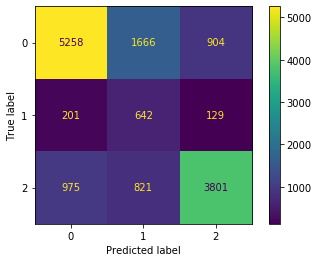

In [167]:
eval_model(logreg,X_train_scaled_smoted,y_train_smoted,X_test_scaled_smoted,y_test)

Logistic Regression performed worse overall with smoted data.

## XGBoost

Training Precision:  0.7542057391832175
Testing Precision:  0.6000156886325945



Training Recall:  0.7455257982824725
Testing Recall:  0.6162721867874231



Training Accuracy:  0.7455257982824725
Testing Accuracy:  0.7068139195665764



Training F1-Score:  0.7438383259526514
Testing F1-Score:  0.596173839970643



              precision    recall  f1-score   support

           0       0.75      0.81      0.78      7828
           1       0.25      0.43      0.32       972
           2       0.80      0.62      0.70      5597

    accuracy                           0.71     14397
   macro avg       0.60      0.62      0.60     14397
weighted avg       0.74      0.71      0.71     14397



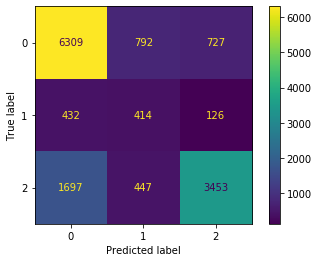

In [170]:
XG_model = xgb.XGBClassifier()
XG_model.fit(X_train_smoted,y_train_smoted)
eval_model(XG_model,X_train_smoted,y_train_smoted,X_test,y_test)

XGBoost also did better with the unbalanced dataset than the balanced.

# HyperParameter Tuning

The best base models was Random Forest. However I keep hearing how XGBoost is great for modeling so going to HyperParameter tune both Random Forest and XGBoost.

## Random Forest

In [156]:
Forest_gs = RandomForestClassifier()
mean_Forest_model_cv_score = np.mean(cross_val_score(Forest_gs, X_train, y_train, cv=3))
mean_Forest_model_cv_score

0.7833344909819177

In [157]:
Forest_param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 6]
}

In [158]:
gs_Forest_model = GridSearchCV(Forest_gs, Forest_param_grid, cv=3)
gs_Forest_model.fit(X_train,y_train)
gs_Forest_model.best_score_

0.7919473964483341

In [159]:
gs_Forest_model.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 150}

The best parameters seems to be that the criterion is entropy, min_samples_leaf is 1, min_samples_split is 5 and n_estimators is 150. It only improved the model slighthly. The only parameter that stayed at default was min_samples_leaf. 

In [161]:
Forest_param_grid_2 = {
    'n_estimators': [150],
    'criterion': ['entropy'],
    'min_samples_split': [5],
    'max_depth': [5, 25, 50, 100, None],
    'max_leaf_nodes': [50, 100, 300, None]
}

In [163]:
Forest_gs_2 = RandomForestClassifier()
gs_Forest_model_2 = GridSearchCV(Forest_gs_2, Forest_param_grid_2, cv=3)
gs_Forest_model_2.fit(X_train,y_train)
gs_Forest_model_2.best_params_

{'criterion': 'entropy',
 'max_depth': 100,
 'max_leaf_nodes': None,
 'min_samples_split': 5,
 'n_estimators': 150}

This is surprising, the optimal max_depth was 100, I was thinking it was going to be None. Going to run another grid search to see if there is a more optimal max_depth.

In [168]:
Forest_param_grid_3 = {
    'n_estimators': [150],
    'criterion': ['entropy'],
    'min_samples_split': [5],
    'max_depth': [80, 90, 100, 110, 120],
    'max_leaf_nodes': [None]
}

In [169]:
Forest_gs_3 = RandomForestClassifier()
gs_Forest_model_3 = GridSearchCV(Forest_gs_3, Forest_param_grid_3, cv=3)
gs_Forest_model_3.fit(X_train,y_train)
gs_Forest_model_3.best_params_

{'criterion': 'entropy',
 'max_depth': 90,
 'max_leaf_nodes': None,
 'min_samples_split': 5,
 'n_estimators': 150}

The actual optimal max_depth seems to be 90.

## XG Boost (not going to do)

In [155]:
XG_param_grid = {
    "learning_rate": [0.1, 0.3],
    'max_depth': [3,6],
    'min_child_weight': [1,5,10],
    'subsample': [0.5,0.7,1],
    'n_estimators': [30, 100, 250],
}

In [157]:
# was taking too long to run, will come back and rerun this.
gs_XG = GridSearchCV(XG_model, XG_param_grid, scoring='accuracy', cv=0, n_jobs=2)
gs_XG.fit(X_train, y_train)

best_parameters_XG = gs_XG.best_params_

KeyboardInterrupt: 

# Final model using hyper parameter settings

## Random Forest

We will implement the hyper parameter variable found in section 7 here.

Training Precision:  0.9456833822341032
Testing Precision:  0.7299674346055811



Training Recall:  0.8763847003014088
Testing Recall:  0.655119928982146



Training Accuracy:  0.9467944710703619
Testing Accuracy:  0.8050982843647982



Training F1-Score:  0.9054908003065257
Testing F1-Score:  0.6790325772351445



              precision    recall  f1-score   support

           0       0.81      0.89      0.85      7828
           1       0.55      0.30      0.39       972
           2       0.83      0.77      0.80      5597

    accuracy                           0.81     14397
   macro avg       0.73      0.66      0.68     14397
weighted avg       0.80      0.81      0.80     14397



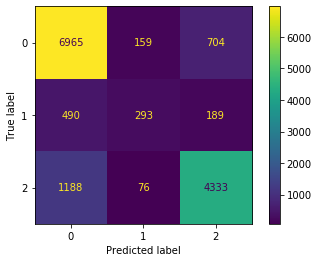

In [171]:
Forest_model_4 = RandomForestClassifier(criterion='entropy',min_samples_split=5,
                                        n_estimators=150, max_depth=90)
Forest_model_4.fit(X_train,y_train)
eval_model(Forest_model_4,X_train,y_train,X_test,y_test)

## Most important features for the model

The most important features for the model seems to be the gps_height, longitude, latitude, population, and quantity_enough.

In [172]:
Forest_model_4.feature_importances_

array([2.15869391e-02, 4.81193047e-02, 9.96057510e-02, ...,
       9.11137078e-05, 2.22142732e-04, 4.18701306e-03])

In [173]:
selector = SelectFromModel(estimator=Forest_model_4,prefit=True,threshold='30*mean')

In [174]:
selected_feat= X_train_smoted.columns[(selector.get_support())]
len(selected_feat)

5

In [175]:
selector.get_support()

array([False,  True,  True, ..., False, False, False])

In [176]:
selected_feat

Index(['gps_height', 'longitude', 'latitude', 'population', 'quantity_enough'], dtype='object')

# Conclusion

In conclusion, the greatest model for this project was Random Forest. After EDA nad HyperParameter tuning, the model was able to achieve a overall accuracy score of 0.8051. As well as a recall score of 0.77 on non-functional wells. The final model is signifiantly better when compared to the baseline model, which was the Dummy classifier. The baseline model had a accuracy score of 0.3258 and a non-functional well recall score of 0.33.

# Future Work (going back and doing more pre-processing)

In [220]:
FutureTrial_X_train = X_train
FutureTrial_y_train = y_train
FutureTrial_X_test = X_test
FutureTrial_y_test = y_test

In [221]:
# FutureTrial_X_train
FutureTrial_X_train['target'] = y_train

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [222]:
FutureTrial_X_train.head()

,amount_tsh,gps_height,longitude,latitude,population,date_recorded_2004-01,date_recorded_2004-03,date_recorded_2004-04,date_recorded_2004-05,date_recorded_2004-06,date_recorded_2004-07,date_recorded_2004-08,date_recorded_2004-09,date_recorded_2004-12,date_recorded_2011-01,date_recorded_2011-02,date_recorded_2011-03,date_recorded_2011-04,date_recorded_2011-05,date_recorded_2011-06,date_recorded_2011-07,date_recorded_2011-08,date_recorded_2011-09,date_recorded_2011-10,date_recorded_2011-11,...,Age_38,Age_39,Age_40,Age_41,Age_42,Age_43,Age_44,Age_45,Age_46,Age_47,Age_48,Age_49,Age_50,Age_51,Age_52,Age_53,Age_54,Age_55,Age_56,Age_57,Age_58,Age_59,Age_60,Age_Unknown,target
28930,NaN,0,32.851457,-9.144668,NaN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
32978,200.0,1762,34.610057,-9.780353,53.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
52550,1000.0,0,38.803030,-4.861744,500.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
53830,6.0,1428,37.497841,-3.331576,100.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15379,100.0,1938,35.907566,-8.104959,150.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Going to try KNN Imputation on some continuous variables

### Amount_tsh

Replacing all 0 values in amount_tsh for KNN imputation.

In [195]:
amount_check = FutureTrial_X_train[FutureTrial_X_train['amount_tsh']==0]

In [198]:
# There is no clear target variable for the 0 category in amount_tsh, lets go ahead and knn impute it.
amount_check.target.value_counts()

0    14150
2    13710
1     2004
Name: target, dtype: int64

In [213]:
len(amount_check)/len(FutureTrial_X_train)

0.6914403463684564

In [223]:
FutureTrial_X_train['amount_tsh'].replace(to_replace = 0,value= np.nan,inplace=True)
FutureTrial_X_train.amount_tsh.isna().sum()

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


29864

### Population

Prepering population for knn impuation. 0 for population seems like a placeholder and looks like it accounts for a third of the train set. The population of 0 does not seem to indicate having a different distribution of target variables.

In [206]:
population_test = FutureTrial_X_train[FutureTrial_X_train['population']==0]

In [207]:
population_test.target.value_counts()

0    7820
2    5863
1    1038
Name: target, dtype: int64

In [208]:
FutureTrial_X_train.target.value_counts()

0    23561
2    16671
1     2959
Name: target, dtype: int64

In [210]:
len(population_test)/len(FutureTrial_X_train)

0.340834896158922

In [211]:
len(population_test)

14721

In [224]:
FutureTrial_X_train['population'].replace(to_replace = 0,value= np.nan,inplace=True)
FutureTrial_X_train.population.isna().sum()

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


14721

### Implement KNN Imputation

In [225]:
scalertest = MinMaxScaler()
FutureTrial_X_train = pd.DataFrame(scalertest.fit_transform(FutureTrial_X_train),
                                   columns = FutureTrial_X_train.columns)

In [227]:
imputer = KNNImputer(n_neighbors=5)
FutureTrial_X_train = pd.DataFrame(imputer.fit_transform(FutureTrial_X_train),
                                   columns = FutureTrial_X_train.columns)

amount_tsh     0
gps_height     0
longitude      0
latitude       0
population     0
              ..
Age_58         0
Age_59         0
Age_60         0
Age_Unknown    0
target         0
Length: 1237, dtype: int64

In [228]:
FutureTrial_X_train.isna().sum()

amount_tsh     0
gps_height     0
longitude      0
latitude       0
population     0
              ..
Age_58         0
Age_59         0
Age_60         0
Age_Unknown    0
target         0
Length: 1237, dtype: int64

# Testing the test set provided by DataDriven

In [183]:
DataDrivenSubmission = pd.read_csv('TestSet.csv')
DataDrivenSubmission.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


# Misc, making figures for Presentation

In [354]:
Full_data.gps

(57588, 27)

In [394]:
df.status_group.value_counts()

functional                 31389
non functional             22268
functional needs repair     3931
Name: status_group, dtype: int64

In [395]:
test8 = df[df['quantity_enough']==0]
test9 = df[df['quantity_enough']==1]

Text(0, 0.5, 'Well Counts')

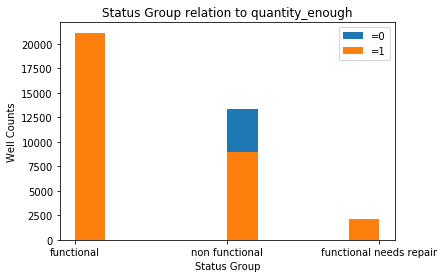

In [397]:
plt.hist(test8['status_group'],label='=0')
plt.hist(test9['status_group'], label='=1')
plt.legend()
plt.title('Status Group relation to quantity_enough')
plt.xlabel('Status Group')
plt.ylabel('Well Counts')

In [434]:
X_train_smoted.shape

(70683, 1236)